<a href="https://colab.research.google.com/github/oluwafemidiakhoa/Mindserach/blob/master/Decoding_Alzheimer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import zipfile
import os

# Define the path to the ZIP file and the extraction destination
zip_file_path = '/content/olunew.zip'
extraction_path = '/content/extracted_folder'

# Create the extraction directory if it doesn't exist
os.makedirs(extraction_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

print("Extraction completed!")


Extraction completed!


In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load the dataset
df = pd.read_csv('/content/extracted_folder/alzheimers_disease_patient_data.csv')

# Separate features and target variable
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Verify the shape of the preprocessed data
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Get feature names after preprocessing
feature_names = list(numerical_cols) + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))


X_train shape: (1719, 34), X_test shape: (430, 34)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize the model
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print(classification_report(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.91      0.98      0.95       277
           1       0.96      0.83      0.89       153

    accuracy                           0.93       430
   macro avg       0.94      0.91      0.92       430
weighted avg       0.93      0.93      0.93       430

AUC-ROC: 0.9844741747481183


In [17]:
!pip install shap lime

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/extracted_folder/alzheimers_disease_patient_data.csv')

# Separate features and target variable
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Verify the shape of the preprocessed data
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Get feature names after preprocessing
feature_names = list(numerical_cols) + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))

# Model Development
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Model Evaluation
print(classification_report(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, y_prob))

# SHAP Explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Correct SHAP values for the positive class (binary classification)
shap_values_class = shap_values[1]

# Check the shape of SHAP values and X_test
print(f"shap_values_class shape: {shap_values_class.shape}, X_test shape: {X_test.shape}")

# Verify the shape alignment
assert shap_values_class.shape == X_test.shape, "Mismatch between SHAP values and X_test"

# SHAP summary plot
shap.summary_plot(shap_values_class, X_test, feature_names=feature_names)

# SHAP dependency plot for a specific feature
shap.dependence_plot('Age', shap_values_class, X_test, feature_names=feature_names)

# LIME Explainability
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names,
                                                        class_names=['No Alzheimer', 'Alzheimer'],
                                                        discretize_continuous=True)
i = 1  # Index of the test instance
exp = lime_explainer.explain_instance(X_test[i], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

# Visualization
shap.force_plot(explainer.expected_value[1], shap_values_class[i], X_test[i], feature_names=feature_names, matplotlib=True)
exp.as_pyplot_figure()
plt.show()


X_train shape: (1719, 34), X_test shape: (430, 34)
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       277
           1       0.96      0.83      0.89       153

    accuracy                           0.93       430
   macro avg       0.94      0.91      0.92       430
weighted avg       0.93      0.93      0.93       430

AUC-ROC: 0.9844741747481183
shap_values_class shape: (34, 2), X_test shape: (430, 34)


AssertionError: Mismatch between SHAP values and X_test

X_train shape: (1719, 34), X_test shape: (430, 34)
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       277
           1       0.96      0.83      0.89       153

    accuracy                           0.93       430
   macro avg       0.94      0.91      0.92       430
weighted avg       0.93      0.93      0.93       430

AUC-ROC: 0.9844741747481183
shap_values_class shape: (430, 34), X_test shape: (430, 34)


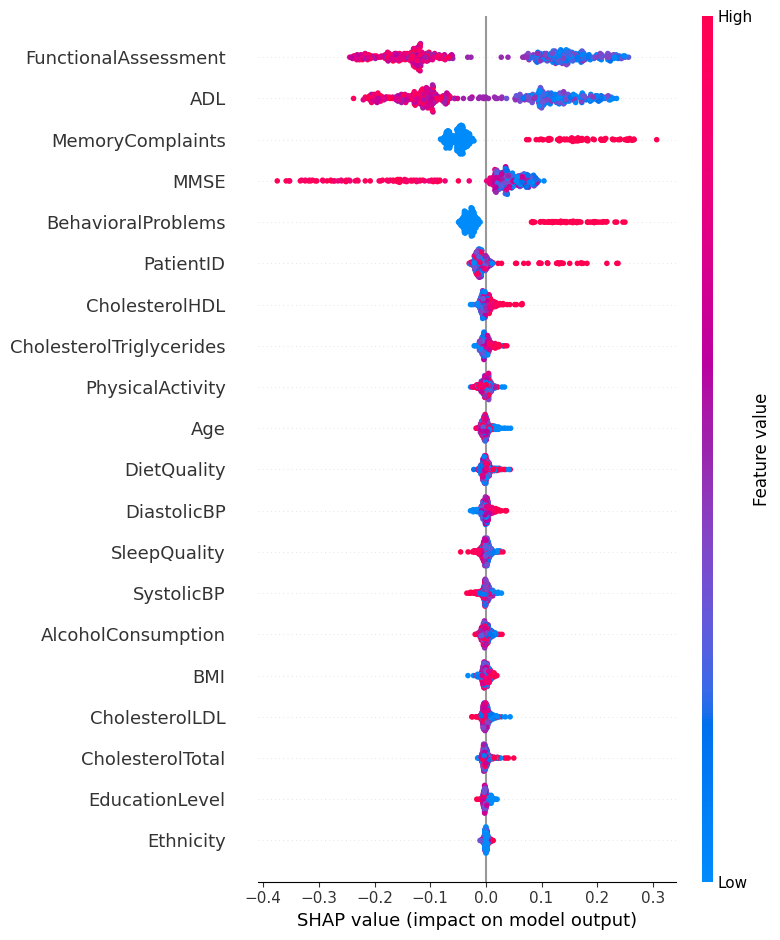

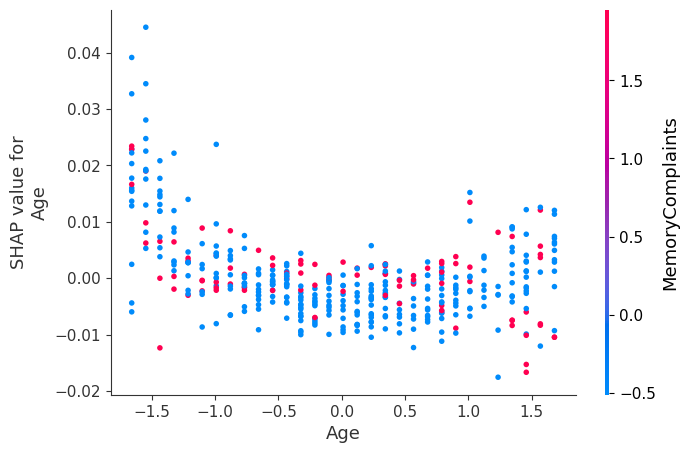

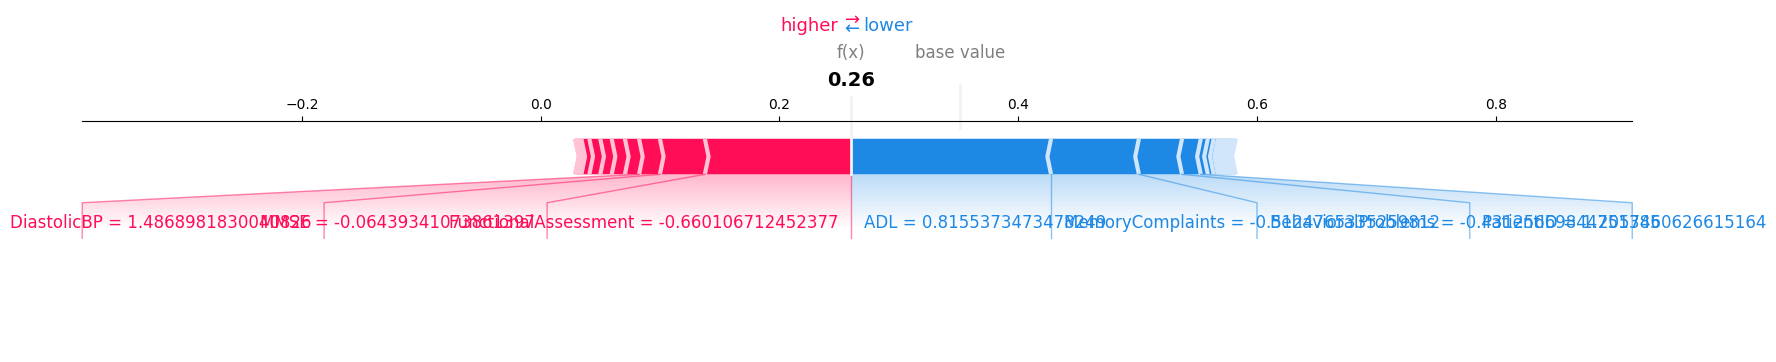

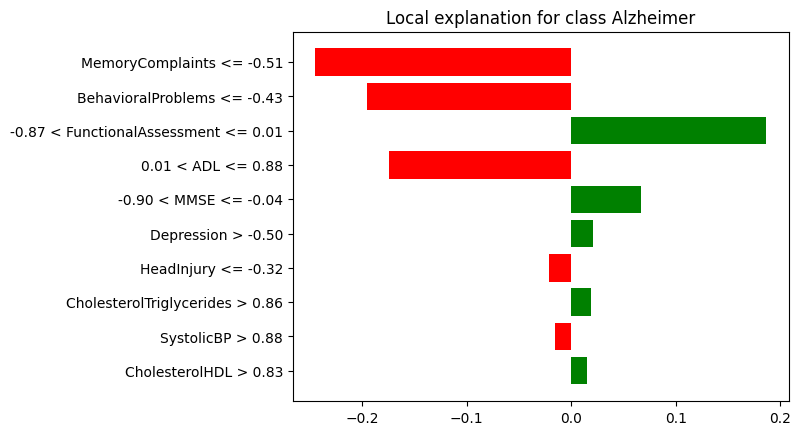

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import shap
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/extracted_folder/alzheimers_disease_patient_data.csv')

# Separate features and target variable
X = df.drop(columns=['Diagnosis'])
y = df['Diagnosis']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

# Verify the shape of the preprocessed data
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")

# Get feature names after preprocessing
feature_names = list(numerical_cols) + list(preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_cols))

# Model Development
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Model Evaluation
print(classification_report(y_test, y_pred))
print('AUC-ROC:', roc_auc_score(y_test, y_prob))

# SHAP Explainability
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# Extract SHAP values for the positive class
shap_values_class = shap_values[:, :, 1]  # Extracting for class 1 (positive class)

# Now, shap_values_class should have the shape (430, 34)
print(f"shap_values_class shape: {shap_values_class.shape}, X_test shape: {X_test.shape}")

# Ensure the shapes now match
assert shap_values_class.shape == X_test.shape, "Mismatch between SHAP values and X_test"

# SHAP summary plot
shap.summary_plot(shap_values_class, X_test, feature_names=feature_names)

# SHAP dependency plot for a specific feature
shap.dependence_plot('Age', shap_values_class, X_test, feature_names=feature_names)

# LIME Explainability
lime_explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=feature_names,
                                                        class_names=['No Alzheimer', 'Alzheimer'],
                                                        discretize_continuous=True)
i = 1  # Index of the test instance
exp = lime_explainer.explain_instance(X_test[i], model.predict_proba, num_features=10)
exp.show_in_notebook(show_table=True)

# Visualization
shap.force_plot(explainer.expected_value[1], shap_values_class[i], X_test[i], feature_names=feature_names, matplotlib=True)
exp.as_pyplot_figure()
plt.show()
